In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.emb_manipulator as em

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("020422")] 
#file = '022822_postpartum_moms_20part_emb_ami.csv'
file = '03016_diarized_pyv2.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down_unscaled = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down_unscaled)

#egemap (88 features) for each participant
#gemap_file = '040122_segmented_postpartum_moms_gemaps'
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
#gemap_file = '040622_segmented_postpartum_moms_gemaps_5sec.csv'
gemap_unscaled = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(emb_down_unscaled.drop(columns='part_id'))
emb_down = pd.DataFrame(scaler.transform(emb_down_unscaled.drop(columns='part_id')))
emb_down['part_id'] = emb_down_unscaled.part_id.to_numpy()

scaler_gemap = StandardScaler()
scaler_gemap.fit(gemap_unscaled.drop(columns='part_id'))
gemap = pd.DataFrame(scaler_gemap.transform(gemap_unscaled.drop(columns='part_id')))
gemap['part_id'] = gemap_unscaled.part_id.to_numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
seeds = np.arange(200)

#corr_coeff = pd.DataFrame()
corr_coeff = []
for s in seeds:
    clear_output(wait=True)
    print("Processing" + str(s))
    test_subset_labeled = emb_down.groupby('part_id').sample(n=5, random_state=s)
    train_subset_labeled = emb_down.drop(test_subset_labeled.index)

    train = train_subset_labeled.drop(columns='part_id').to_numpy()
    train_labels = train_subset_labeled.part_id.to_numpy()

    test = test_subset_labeled.drop(columns='part_id').to_numpy()
    test_labels = test_subset_labeled.part_id.to_numpy()

    mapper = umap.UMAP(n_neighbors=10).fit(train, train_labels)
    train_embedding = mapper.embedding_
    train_embedding = pd.DataFrame(train_embedding, columns={'dim0','dim1'})
    train_embedding['part_id'] = train_labels

    test_embedding = mapper.transform(test)
    test_embedding = pd.DataFrame(test_embedding, columns={'dim0','dim1'})
    test_embedding['part_id'] = test_labels

    train_haus = dm.hausdorff_distances(train_embedding)
    metric_learning_haus = dm.hausdorff_distances(pd.concat([test_embedding,train_embedding]))

    df_1 = pd.DataFrame(train_haus.to_numpy().flatten()).dropna()
    df_2 = pd.DataFrame(metric_learning_haus.to_numpy().flatten()).dropna()
    corr_coeff.append(df_1.corrwith(df_2))

Processing row 11, col 13


<AxesSubplot:ylabel='Count'>

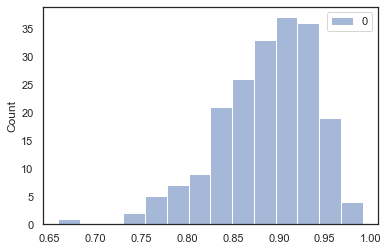

In [19]:
sns.histplot(np.array(corr_coeff))